# Cox Proportional Hazards Model

## Introduction

### Cox Proportional Hazards Regression Model

Survival analysis is a branch of statistics for analysing the expected duration of time until one or more events occur.<br>
There are various models used for survival analysis. However, in this project we'll only cover two of them:
 * Kaplan Meier Survival Function
    * Model with a single explanatory variable (time). i.o.w. Survival rates will only vary in function of time
 * Cox Proportional Hazards Regression
   * Model with a n-explanatory variables represented in the form of a simple linear regression.<br><br>
 
   $h_i(t) = h_0(t)*e^{\beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n}$
   
Where: 
   * $h_0(t)$ is the baseline hazard function<br>
   
Interpretation of parameters:

* $\beta_j$ represents the increase in the log hazard ratio given a unit increase in $X_j$ (holding all other factors fixed)
* $\beta_j <0 \rightarrow$ increasing $X_j$ will decrease the risk factor. Which implies longer survival times

   
   

### Objective

The objective of the Cox Proportional Hazard model is to evaluate the impact of a set of explanatory variables on the survival variable. 

### Problem Statement

We want to determine a model that explains the survival rate (probability of an employee not leaving the company) in function of time and all other independent variables in the dataset

## EDA

**Importing libraries & data**

In [606]:
import pandas as pd 
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns
#survival analysis libraries 
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [607]:
df = pd.read_excel('Attrition.xlsx')
#attrition --> departure of an employee 
#yes --> employee left
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [608]:
# verifying there's no null values in any column 
# 1 --> no null values at all 
(df.isna().sum() == 0).count()/len(df.columns)

1.0

**Proportion of variables by data types**

In [609]:
from pyparsing import col
from sklearn.utils import column_or_1d
d_1 = (sum(df.dtypes.values == 'int64')+sum(df.dtypes.values == 'object'))/len(df.columns) #integers
d_2 = sum(df.dtypes.values == 'float32')/len(df.columns)#floats 

#funciion for finding the ratio of columns wih at least one null value 
def missingCols(data):
    i = 0
    for col in data.columns:
        if data[col].isna().sum() > 0:
            i += 1
    return i/len(data.columns)

d_3 = missingCols(df) #all cols missing

#function for calculating the ratio of complete rows a df has
def completeRows(data):
    tot = 0
    for i in data.index:
        if data.iloc[i,:].isna().any() == False:
            tot += 1
    return tot/len(data)

d_4 = completeRows(df) #complete 
d_5 = df.isna().sum().sum()/df.shape[0]*df.shape[1] #missing observations

d_1,d_2,d_3,d_4,d_5

(1.0, 0.0, 0.0, 1.0, 0.0)

For this specific dataframe it can be unnecessary to analyze these metrics

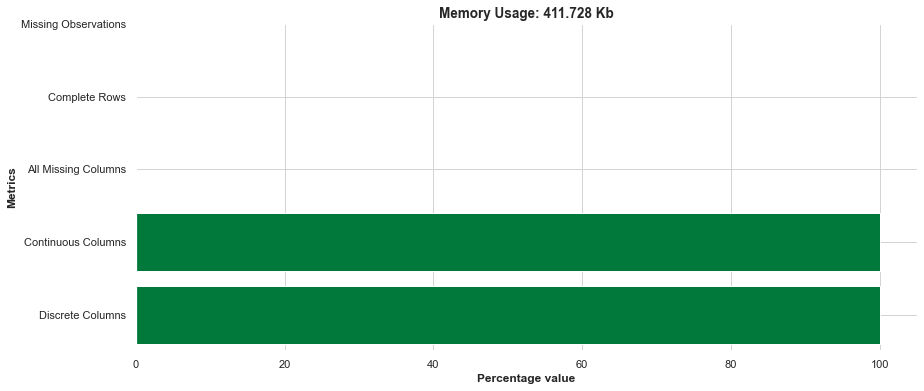

In [610]:
plt.barh([d_1,d_2,d_3,d_4,d_5],width=100, color=['#00793B'], label=['w','s','l','c','l'])
plt.title('Memory Usage: '+str(df.memory_usage().sum()/1000)+' Kb', weight=800, size=13.5)
plt.ylabel('Metrics', weight=800, size=12)
plt.xlabel('Percentage value', weight=800, size=12)
#changing columns names
y = np.arange(5)
plt.yticks(y,['Discrete Columns','Continuous Columns','All Missing Columns','Complete Rows','Missing Observations'])
plt.show()

***Number of null values by variable***

In ths specific scenario we have no columns with null values (idyllic situation)

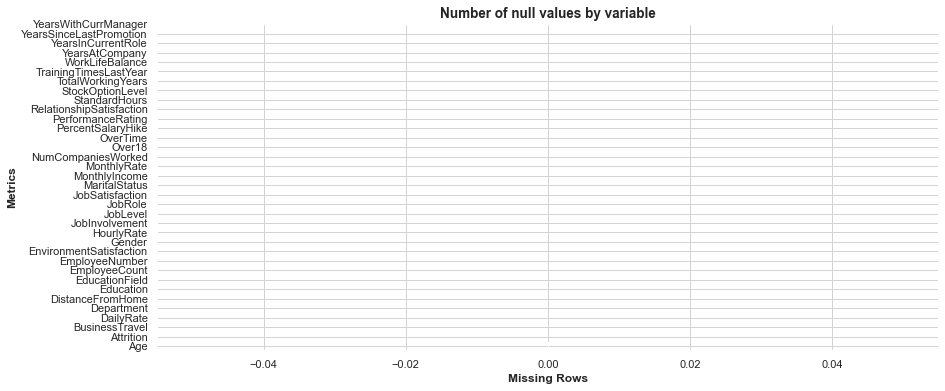

In [611]:
plt.barh(df.isna().sum().values, width=max(df.isna().sum()), color=['#00793B'])
plt.title('Number of null values by variable', weight=800, size=13.5)
plt.ylabel('Metrics', weight=800, size=12)
plt.xlabel('Missing Rows', weight=800, size=12)
#changing columns names
y = np.arange(len(df.columns))
plt.yticks(y,df.isna().sum().index)
plt.show()

***Proportion of variable by data types***<br>
*Additional Plot*

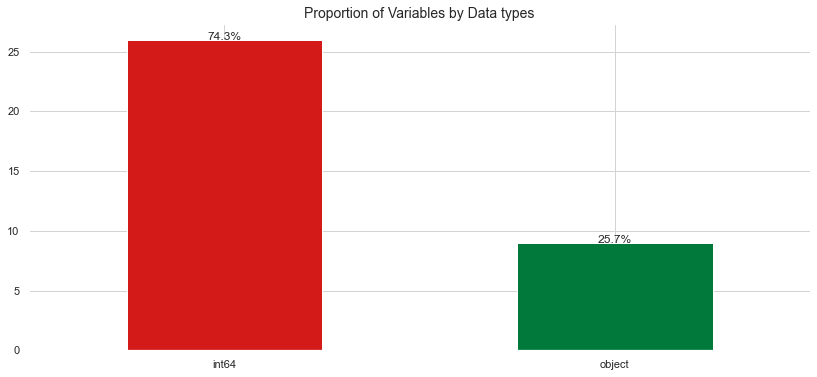

In [612]:
ax = df.dtypes.value_counts().plot(kind='bar',rot=0, color=['#D41919','#00793B'])
plt.title('Proportion of Variables by Data types', size=14)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/float(len(df.columns)))
    #position of label in x axis
    x = p.get_x() + p.get_width() - 0.25
    #position of label in y axis
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

***Levels of categorical variables***

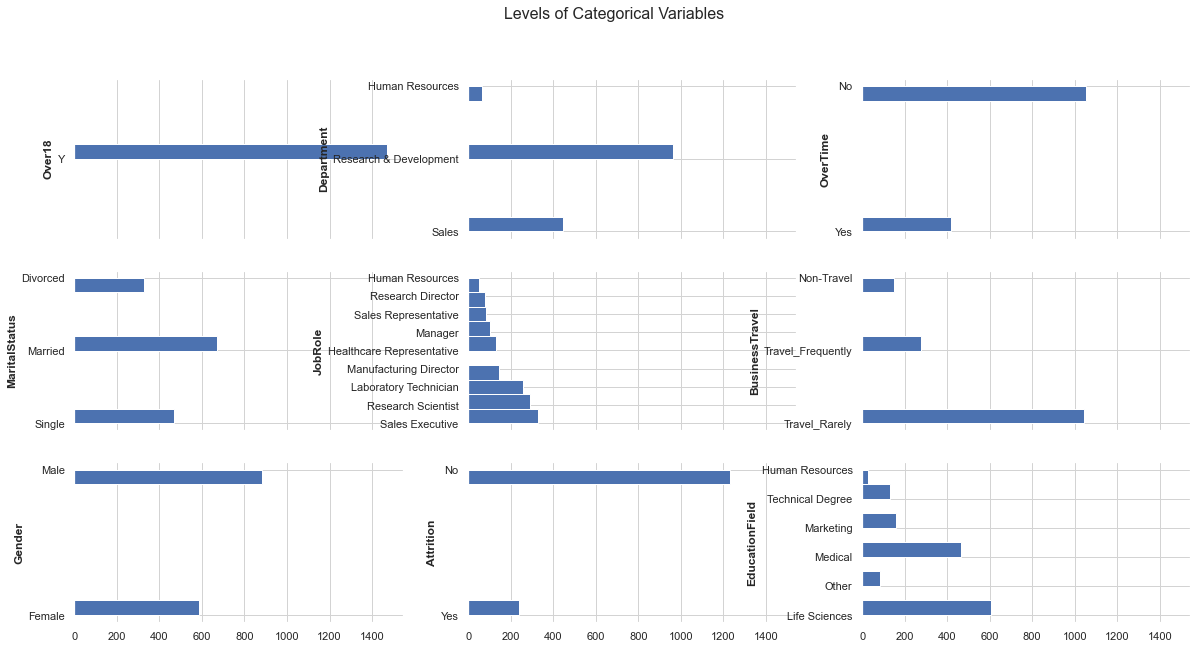

In [613]:
#creating array containing names of all categorical variables
categorical = list(set(df.columns) - set(df._get_numeric_data().columns))

#creating a set of subplots to graph the distribution of all variables in our array columns
fig, ax = plt.subplots(3,3, sharex=True, sharey=False, figsize=(20,10))
fig.suptitle('Levels of Categorical Variables', size=16)
cat = 0
for i in range(0,3):
    for j in range(0,3):
        ax[i,j].hist(df[categorical[cat]], orientation='horizontal')
        ax[i,j].set_ylabel(categorical[cat], weight='bold')
        cat += 1

***Distribution of Continuous Variables***

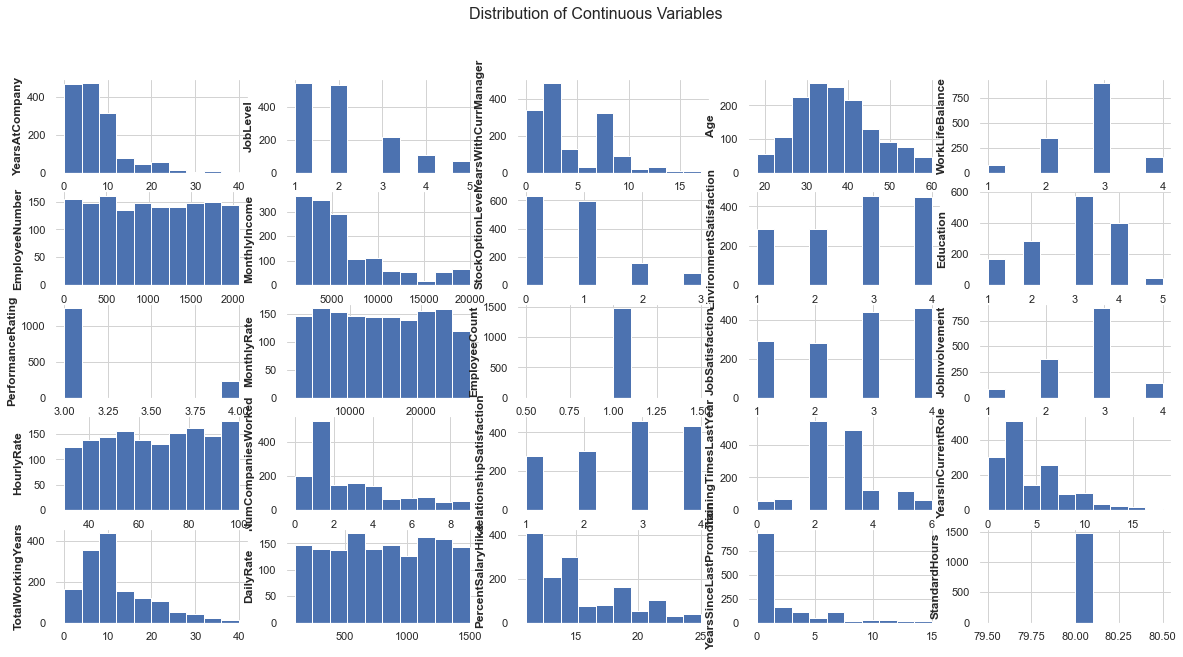

In [614]:
#creating array containing names of all continuous variables
continuous = list(set(df._get_numeric_data().columns))

#creating a set of subplots to graph the distribution of all variables in our array columns
fig, ax = plt.subplots(5,5, sharex=False, sharey=False, figsize=(20,10))
fig.suptitle('Distribution of Continuous Variables', size=16)
cat = 0
for i in range(0,5):
    for j in range(0,5):
        ax[i,j].hist(df[continuous[cat]])
        ax[i,j].set_ylabel(continuous[cat], weight='bold')
        cat += 1

## Data Cleansing

In [615]:
#we only need to change the attrition variable to a binary one 
df['Attrition'] = [1 if x=='Yes' else 0 for x in df['Attrition']]

## Survival Functions 

### Kaplan-Meier Curve

***Kaplan-Meier Survival Function***<br>
*KM Plot with 95% Confidence Interval*

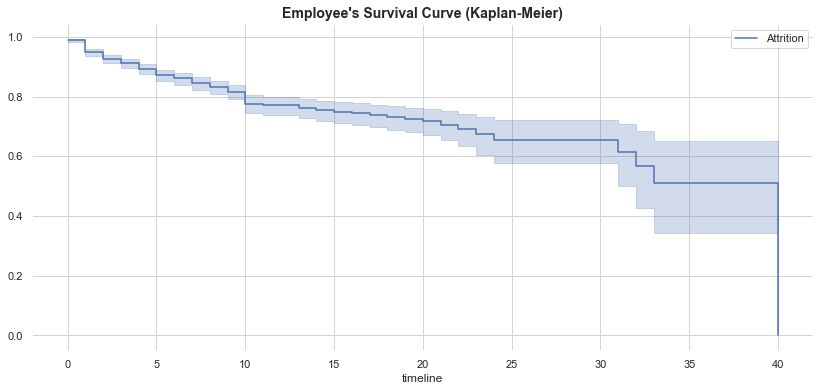

In [616]:
kmf = KaplanMeierFitter()
#fitting model 
kmf.fit(durations = df.YearsAtCompany, event_observed= df.Attrition, label='Attrition') #change legend name
sns.set(rc={'axes.facecolor':'white','grid.color':'lightgray', 'figure.facecolor':'white', "figure.figsize":(14, 6)})
plt.title("Employee's Survival Curve (Kaplan-Meier)", size=14, weight=600)
kmf.plot_survival_function()
plt.show()

**Nelson Aalen's Cumulative Hazard Function***

<AxesSubplot:title={'center':'Employees Cumulative Hazard'}, xlabel='timeline'>

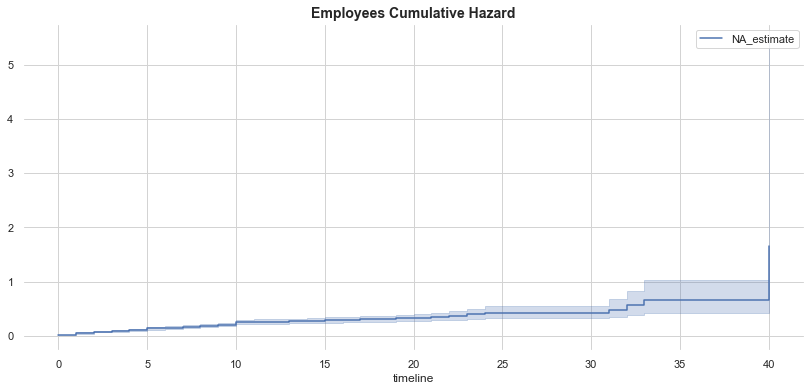

In [617]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter()
naf.fit(df.YearsAtCompany, df.Attrition)
plt.title("Employees Cumulative Hazard", size=14, weight=600)
plt.legend('Attrition')
naf.plot_cumulative_hazard()

['Over18', 'Department', 'OverTime', 'MaritalStatus', 'JobRole', 'BusinessTravel', 'Gender', 'EducationField']


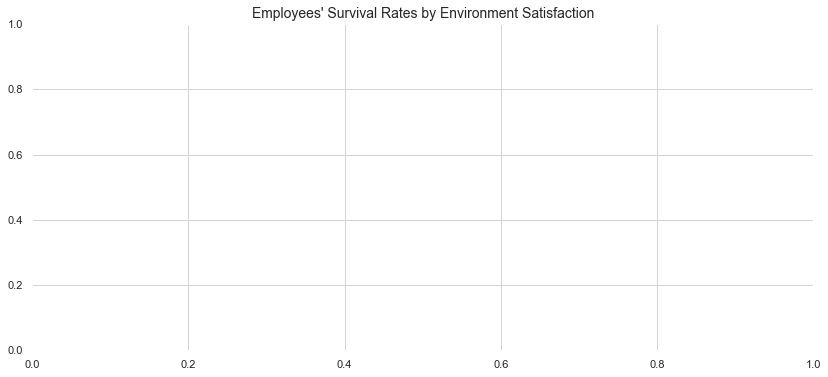

In [618]:
#updating categorical array by removing event variable 
categorical.remove('Attrition')
print(categorical)

#library for displaying values in table format
from lifelines.plotting import add_at_risk_counts

#array with time and observed event values
t = df.YearsAtCompany
event = df.Attrition

kmf = KaplanMeierFitter()
ax = plt.subplot(111)
plt.title("Employees' Survival Rates by Environment Satisfaction", size=14)
#plotting all subplots with very possible value of "Environment Satisfaction"

#plotting function for future iterations
def plotCurves(myCategorical):
     kmf = KaplanMeierFitter()
     ax = plt.subplot(111)
     for p in df[myCategorical].unique():
          satis = df[myCategorical] == p
          kmf.fit(t[satis], event_observed= event[satis], label=p)
          kmf.plot(ax=ax)
     add_at_risk_counts(kmf, ax=ax)
     plt.tight_layout()
     return ax

***Survival Rates for every categorical variable in the dataset***

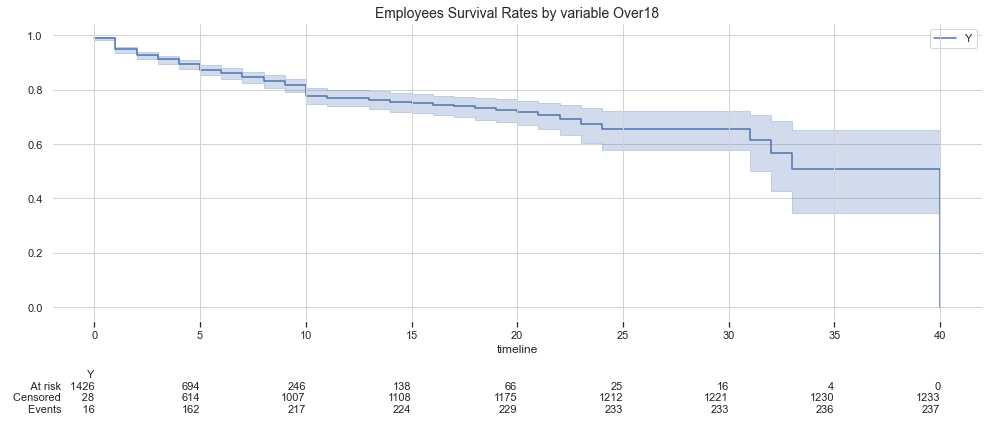

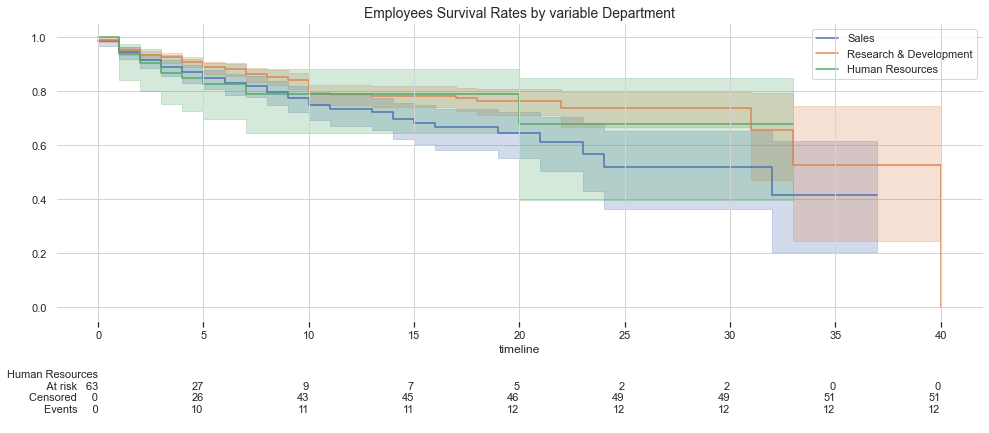

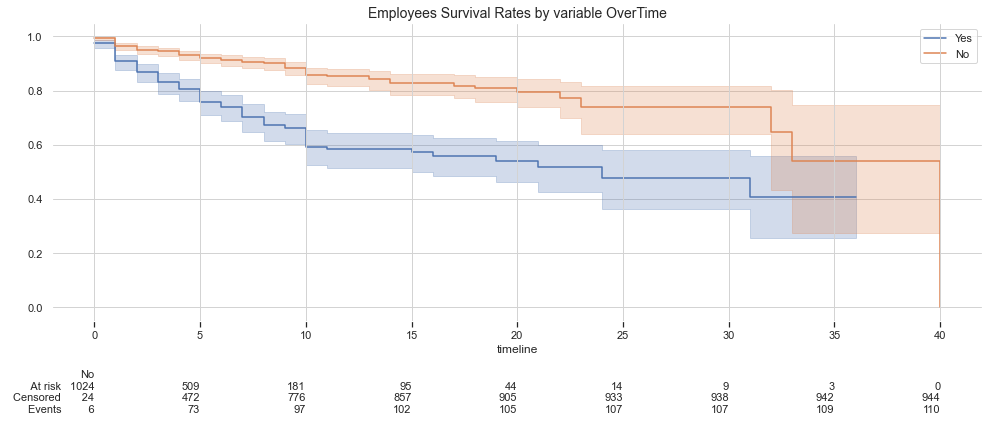

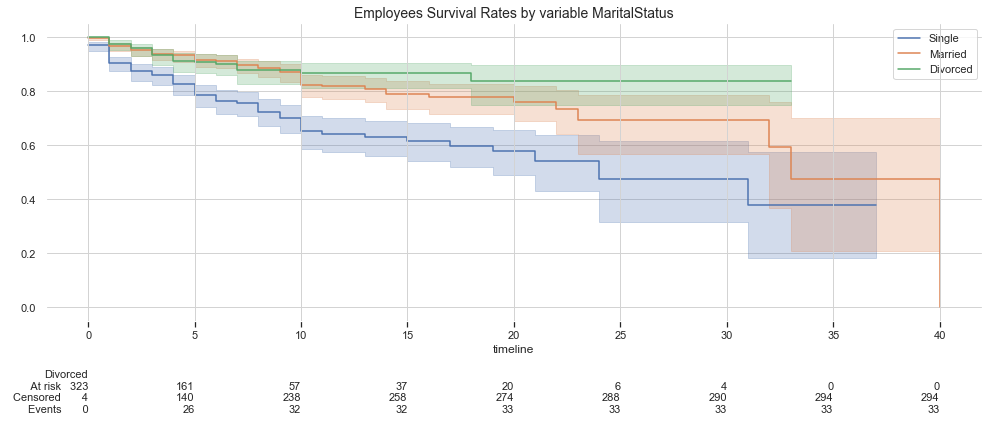

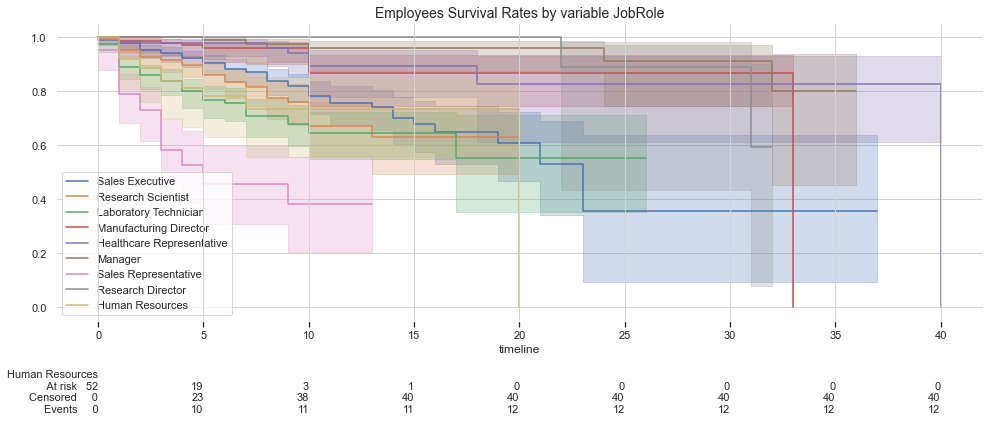

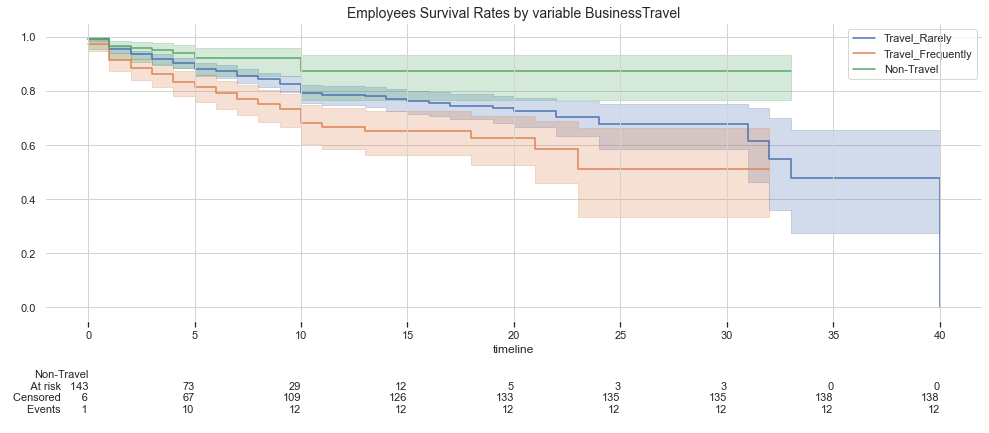

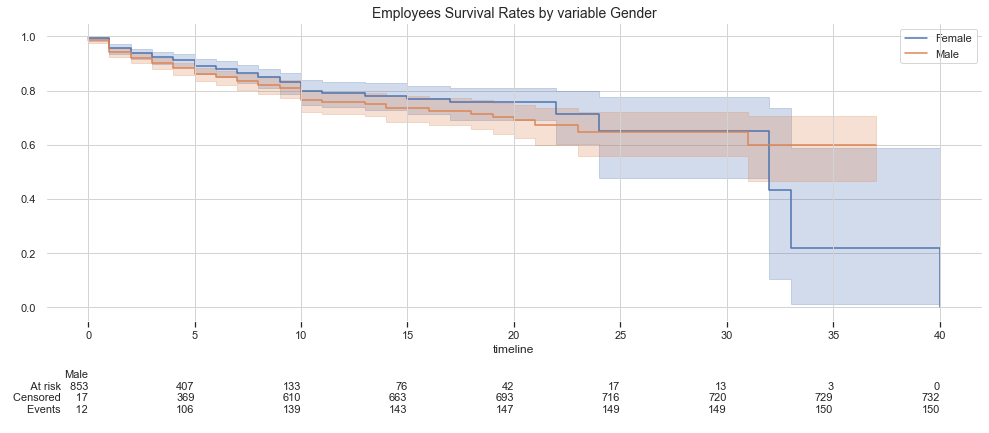

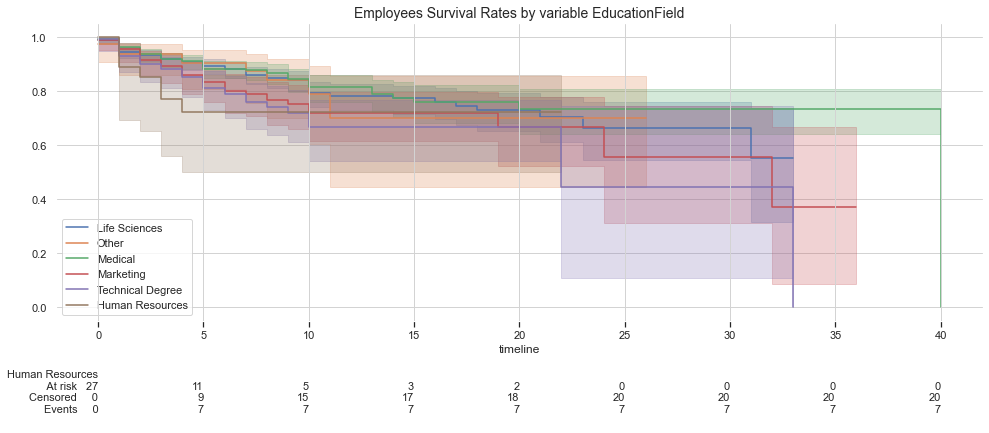

In [619]:
#plotting all function within a loop for efficacy
for i in range(len(categorical)):
    plotCurves(categorical[i])
    plt.title('Employees Survival Rates by variable '+ str(categorical[i]), size=14)
    plt.show()

## Cox Proportional Hazards Model

Using all explanatory variables (continuous and categorical) as beta coefficients for our Cox Proportional Hazards Model

*Job Role Encoding*

In [620]:
#encoding categorical variable using pandas method
dummies_job = pd.get_dummies(df['JobRole'], prefix='JobRole_')
#concatenate with original data
df = pd.concat([df,dummies_job], axis=1)
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,YearsWithCurrManager,JobRole__Healthcare Representative,JobRole__Human Resources,JobRole__Laboratory Technician,JobRole__Manager,JobRole__Manufacturing Director,JobRole__Research Director,JobRole__Research Scientist,JobRole__Sales Executive,JobRole__Sales Representative
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,5,0,0,0,0,0,0,0,1,0
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,7,0,0,0,0,0,0,1,0,0
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,0,0,0,1,0,0,0,0,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,0,0,0,0,0,0,0,1,0,0
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,2,0,0,1,0,0,0,0,0,0


We are only going to use JobRole's dummy variables as our regressors for the Cox Hazards Function

In [623]:
job_roles = dummies_job.copy()
job_roles['YearsAtCompany'] = df.YearsAtCompany
job_roles['Attrition'] = df.Attrition
job_roles.head(3)

,JobRole__Healthcare Representative,JobRole__Human Resources,JobRole__Laboratory Technician,JobRole__Manager,JobRole__Manufacturing Director,JobRole__Research Director,JobRole__Research Scientist,JobRole__Sales Executive,JobRole__Sales Representative,YearsAtCompany,Attrition
0,0,0,0,0,0,0,0,1,0,6,1
1,0,0,0,0,0,0,1,0,0,10,0
2,0,0,1,0,0,0,0,0,0,0,1


To avoid perfect multicollinearity we remove one of the dummy variables from our model

In [627]:
job_roles = job_roles.drop(['JobRole__Healthcare Representative'], axis=1)

In [628]:
#fitting preprocessed data to Cox model
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(job_roles, duration_col='YearsAtCompany', event_col='Attrition')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 237
   partial log-likelihood = -1488.69
         time fit was run = 2022-10-29 13:07:14 UTC

---
                                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                               
JobRole__Human Resources          1.81       6.11       0.46             0.91             2.71                 2.48                15.06
JobRole__Laboratory Technician    1.90       6.69       0.38             1.16             2.65                 3.18                14.10
JobRole__Manager                 -0.92       0.40       0.58            -2.06             0.21                 0.13                 1.24
JobRole__Manufacturing Director   0.25       1.28       0.48            -0.69             1.18                 0.50                 3.24
JobRole__Research Director       -1.17       0.31       0.79            -2.72             0.39                 0.07                 1.47
JobRole__Research Scientist       1.50       4.46       0.39             0.74             2.25                 2.09                 9.53
JobRole__Sales Executive          1.21       3.35       0.38             0.46             1.95                 1.59                 7.04
JobRole__Sales Representative     2.91      18.39       0.40             2.12             3.70                 8.37                40.41

                                  cmp to     z      p   -log2(p)
covariate                                                       
JobRole__Human Resources            0.00  3.93 <0.005      13.51
JobRole__Laboratory Technician      0.00  5.00 <0.005      20.77
JobRole__Manager                    0.00 -1.59   0.11       3.16
JobRole__Manufacturing Director     0.00  0.52   0.61       0.72
JobRole__Research Director          0.00 -1.47   0.14       2.82
JobRole__Research Scientist         0.00  3.86 <0.005      13.11
JobRole__Sales Executive            0.00  3.18 <0.005       9.41
JobRole__Sales Representative       0.00  7.25 <0.005      41.13
---
Concordance = 0.74
Partial AIC = 2993.38
log-likelihood ratio test = 170.87 on 8 df
-log2(p) of ll-ratio test = 106.54

### Interpretation Cox Model's Coefficients

In the Cox proportional Hazard model a higher $\beta$ implies a higher probability of the risk event  of occuring (Leaving the company). Then:<br>
*   $\beta_{HumanResources}\rightarrow $ A person working in Human Resources has $e^{1.81}= $ 6.11% hgher probability of leaving the company than a person working as Healthcare Representative
*   $\beta_{ResearchDirector}\rightarrow $ A person working as Research Director has $e^{-1.17}= $ 0.31% hgher probability of leaving the company than a person working as Healthcare Representative
*   $\beta_{SalesRepresentative}\rightarrow $ A person working as Sales Representative has $e^{2.91}= $ 18.36% hgher probability of leaving the company than a person working as Healthcare Representative


***Plot rankings of regressors in terms of log(hr)***

<AxesSubplot:xlabel='log(HR) (95% CI)'>

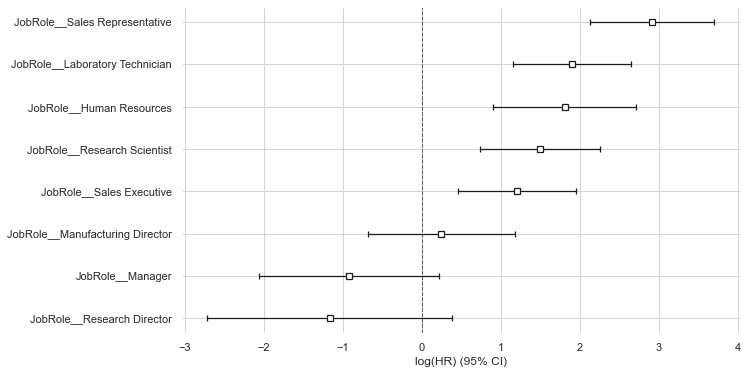

In [629]:
plt.subplots(figsize = (10, 6))
cph.plot()